<a href="https://colab.research.google.com/github/wtrainor/UNET_DAS/blob/main/Monte_carlo_stored_heat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats



#Define variables for statistical distributions

- reservoir volume
- reservoir temperature
- recovery factor
$R_f = \frac{q_{wh}}{q}$

where
$q_{wh}$ is thermal energy from the wellhead 

Recovery factor is tied to the reference/base temperature. Look at Table 4 in Ciriaco et al. >20% looks high

USA Fracture dominated: 5-20%, $\mu=10\%$ "*varies on assumed reservoir size and geometry*"

5% +/-2% for "*wide reservoir definition, reference temp=ambient*"

In [2]:
mu_volume = 5 #5 B&R 10-SAM mean of reservoir volume, km^3
sigma_volume = 2 #standard deviation of reservoir volume, km^3

mu_T_res = 150 #150 B&R 250-SAM #mean of reservoir temperature, deg C
sigma_T_res = 20 #standard deviation of reservoir temperature, deg C

low_R = 0.01 #minimum estimate of recovery factor
mode_R = 0.05 #most likely estimate of recovery factor
high_R = 0.1 #maximum estimate of recovery factor

## USGS Plant Capacity Function
thermal energy in rock and fluid.
I think there was a typo
```
convert m^3 to km^3
```
switched this...

Triangular distribution of Reservoir temperature

In [3]:
min_T = 200
most_likely_T = 230
max_T = 300

Equations 6 & 13 in 
<div class="csl-entry">Ciriaco, A. E., Zarrouk, S. J., &#38; Zakeri, G. (2020). Geothermal resource and reserve assessment methodology: Overview, analysis and future directions. In <i>Renewable and Sustainable Energy Reviews</i> (Vol. 119). Elsevier Ltd. https://doi.org/10.1016/j.rser.2019.109515</div>

which says that 90% of energy comes from rock, not fluid

$U = ((1-\phi)c_{pr}\rho_r + \phi c_{pf} rho_f)(T_{res}-T_{ref})*volume$

In [4]:
def CalculatePlantCapacityStochastic(T_ref = 50, #reference temperature (degC)
                                     c_pf = 4870, #fluid heat capacity J / (kg degC) 
                                     rho_f = 800, #fluid density kg m^-3
                                     phi = 0.1, #porosity
                                     c_pr = 900, #rock heat capacity J / (kg K) 
                                     rho_r = 2900, #rock density kg m^-3
                                     eta_c = 0.1, #Conversion efficiency
                                     lifespan = 20, #in years 
                                     load_factor = 0.8 #load factor
                                    ):
    volume = -1 #quick fix to ensure that volume is positive
    while volume < 0:  #quick fix to ensure that volume is positive
        volume = np.random.normal(mu_volume,sigma_volume)*1e9 #sample volume from normal distribution, convert km^3 to m^3
    T_res = np.random.normal(mu_T_res,sigma_T_res) #sample temperature from normal distribution
    #T_res = np.random.triangular(min_T, most_likely_T, max_T)

    U = ((1-phi)*c_pr*rho_r + phi*c_pf*rho_f)*(T_res-T_ref)*volume

    #R = np.random.beta(a=2, b=18)#sample recovery factor from beta distribution
    #R = np.random.uniform(0.05,0.2)#sample recovery factor from uniform distribution
    R = np.random.triangular(low_R, mode_R, high_R)#sample recovery factor from triangular distribution
    # EQUATION 6 of Ciriaco: THERMAL ENERGY
    MWe = ((U*eta_c*R)/1e6)/(load_factor*lifespan*60*60*24*365)
    return MWe

In [5]:
#?np.random.normal

# Monte Carlo step

In [6]:
num_trials = 500000 #Number of times plant capacity will be calculated will be recalculated
capacities = [CalculatePlantCapacityStochastic() for i in range(num_trials)] #So easy! 

#Obtaining the statistics of the calculated plant capacities
#Below I fit a normal distribution to the calculated capacities 
mu_norm, std_norm = stats.norm.fit(capacities)
#Below I fit a lognormal distribution to the calculated capacities
fitting_params_lognorm  = stats.lognorm.fit(capacities, loc=2.6)  #loc parameter determined by trial and error
lognorm_dist_fitted = stats.lognorm(*fitting_params_lognorm)


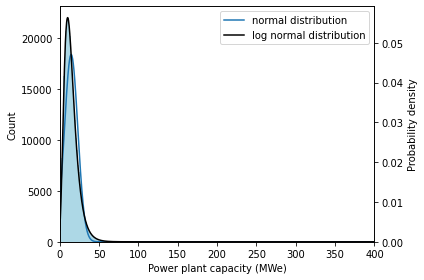

In [7]:
fig, ax = plt.subplots()
ax.hist(capacities, bins=100, color='lightblue')
ax.set_ylabel('Count')
ax.set_xlabel('Power plant capacity (MWe)')
ax.set_xlim(0,400)
ax2 = ax.twinx()
x = np.linspace(0, 400, 1000)
ax2.plot(x, stats.norm.pdf(x, mu_norm, std_norm), label='normal distribution' )
ax2.plot(x, lognorm_dist_fitted.pdf(x), 'k-', label='log normal distribution' )
ax2.set_ylabel('Probability density')
ax2.set_ylim(0)
ax2.legend()
fig.tight_layout()

P10, P50, P90
Use this distribution of MegaWatts for Vprior calculation

In [8]:
np.percentile(capacities, (10, 50, 90))

array([ 5.09209586, 13.065373  , 25.98862964])

# Use `pymc3` instead!

pasting in from `gempy` right now

In [9]:
import pymc3 as pm

In [10]:
import arviz as az

In [11]:
import theano.tensor as tt

In [12]:
# def sample_Energy(resTi,resVoli):
    
#     T_ref = 50, #reference temperature (degC)
#     c_pf = 4870, #fluid heat capacity J / (kg degC) 
#     rho_f = 800, #fluid density kg m^-3
#     phi = 0.1, #porosity
#     c_pr = 900, #rock heat capacity J / (kg K) 
#     rho_r = 2900, #rock density kg m^-3
#     eta_c = 0.1, #Conversion efficiency
#     lifespan = 20, #in years 
#     load_factor = 0.8 #load factor
                                  
#     volume = resVoli*1e9 #sample volume from normal distribution, convert km^3 to m^3
#     T_res = resTi
#     print(T_res,volume)
#     U = ((1-phi)*c_pr*rho_r + phi*c_pf*rho_f)*(T_res-T_ref)*volume
#     return U

# class getTherm(tt.Op):
#     itypes = [tt.fvector]
#     otypes = [tt.dvector]

#     def perform(self, node, inputs, outputs):
#         theta, = inputs
#         print('theta',theta)
#         mu = sample_Energy(theta)#HERE
#         outputs[0][0] = np.array(mu)

# pymc_therm = getTherm()

### Sam's deterministic rock, fluid, plant values

In [13]:
T_ref = 15 #Sam had 50, reference temperature (degC); should this be ambient (15 or 20)? rejection or separation?
           # USGS used 15, Sam had 50
c_pf = 4870 #fluid heat capacity J / (kg degC) 
rho_f = 800 #fluid density kg m^-3
phi = 0.1 #porosity; should be pm.Triangular (lower=0.05,mode=0.05,upper=0.15), Figure 4 of Ciriaco
c_pr = 900 #rock heat capacity J / (kg K) 
rho_r = 2900 #rock density kg m^-3
eta_c = 0.1 #Conversion efficiency
lifespan = 20 #in years 
load_factor = 0.8 #load factor

In [14]:
(1.0-phi)*c_pr*rho_r + (phi*c_pf*rho_f)#*(resT-T_ref)*resVol
#U = ((1-phi)*c_pr*rho_r + phi*c_pf*rho_f)*(T_res-T_ref)*volume
#((1.0-phi)*c_pr*rho_r + (phi*c_pf*rho_f))*(resT-T_ref)*resVol

2738600.0

In [15]:
mu_T_res, sigma_T_res

(150, 20)

## `with pm.Model() as model`

In [16]:
with pm.Model() as model:
#     Z_var = pm.Normal('Z_var', mu=0, sigma=5, dtype='float32', shape=2)
      resT = pm.Normal('resT', mu=mu_T_res, sigma=sigma_T_res, shape=1)
      # resVol = pm.Normal('resVol', mu=mu_volume, sigma=sigma_volume, shape=1)
      resVol = pm.TruncatedNormal('resVol', mu=mu_volume, sigma=sigma_volume, lower=0)
      muU = ((1.0-phi)*c_pr*rho_r + (phi*c_pf*rho_f))*(resT-T_ref)*resVol*1e9 #km**3 to m**3
      # ThermalEnergy = pm.Deterministic('ThermalEnergy', muU)
      RecoveryFactor = pm.Triangular('RecoveryFactor',lower=low_R, c=mode_R, upper=high_R)#sample recovery factor from triangular distribution
      # EQUATION 6 of Ciriaco: THERMAL ENERGY
      MWe = ((muU*eta_c*RecoveryFactor)/1e6)/(load_factor*lifespan*60*60*24*365)
      MegaWatts = pm.Deterministic('MegaWatts', MWe)

In [17]:
#ThermalEnergy #resT # resTandVol  #
MegaWatts

MegaWatts ~ Deterministic

In [18]:
resVol
#resT

resVol ~ TruncatedNormal

9 seconds for 10,000

In [19]:
with model:
#    trace = pm.sample(500, cores=1, chains=1,
#                     step = pm.Metropolis(), tune =50)
   trace = pm.sample(10000, cores=1, chains=1, tune =50) # num_trials instead of 200 ??

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  after removing the cwd from sys.path.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [RecoveryFactor, resVol, resT]


Sampling 1 chain for 50 tune and 10_000 draw iterations (50 + 10_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.9510421725204844, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [20]:
data = az.from_pymc3(trace=trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


### Save / Load the data

In [21]:

#data.to_netcdf('T_resjunk')
#data = az.from_netcdf('T_resjunk')


In [22]:
data.posterior

<xarray.Dataset>
Dimensions:          (MegaWatts_dim_0: 1, chain: 1, draw: 10000, resT_dim_0: 1)
Coordinates:
  * chain            (chain) int64 0
  * draw             (draw) int64 0 1 2 3 4 5 ... 9994 9995 9996 9997 9998 9999
  * resT_dim_0       (resT_dim_0) int64 0
  * MegaWatts_dim_0  (MegaWatts_dim_0) int64 0
Data variables:
    resT             (chain, draw, resT_dim_0) float64 181.2 187.7 ... 126.8
    resVol           (chain, draw) float64 5.374 4.425 7.428 ... 3.932 4.009
    RecoveryFactor   (chain, draw) float64 0.07169 0.05337 ... 0.07141 0.08381
    MegaWatts        (chain, draw, MegaWatts_dim_0) float64 34.76 ... 20.39
Attributes:
    created_at:                 2022-02-23T11:57:40.997815
    arviz_version:              0.11.4
    inference_library:          pymc3
    inference_library_version:  3.11.4
    sampling_time:              13.588584661483765
    tuning_steps:               50

In [23]:
print(np.shape(data.posterior.draw))
print(np.shape(data.posterior.resT))

(10000,)
(1, 10000, 1)


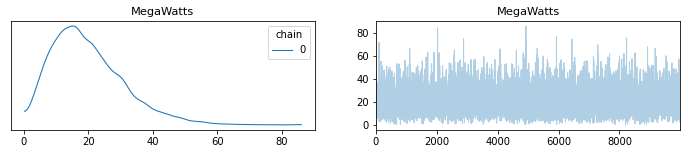

In [24]:
az.plot_trace(data, var_names=['MegaWatts'], legend=True); 

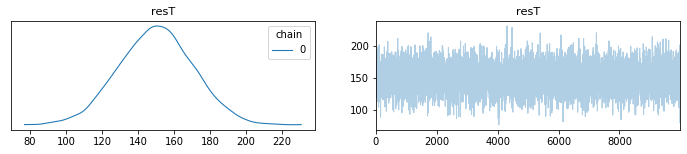

In [25]:
az.plot_trace(data, var_names=['resT'], legend=True); 

5 2


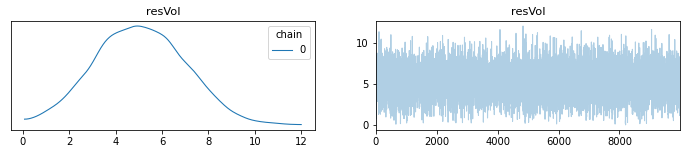

In [26]:
az.plot_trace(data, var_names=['resVol'], legend=True); 
print(mu_volume, sigma_volume)

(0.01, 0.05, 0.1)

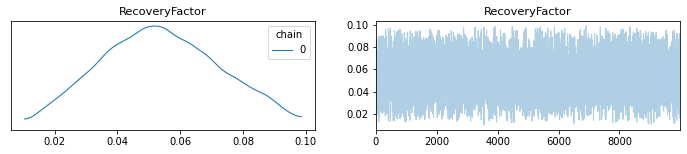

In [66]:
az.plot_trace(data, var_names=['RecoveryFactor'], legend=True); 
low_R, mode_R, high_R

In [29]:
#az.plot_trace(data, var_names=['ThermalEnergy'], legend=True); 
#np.shape(data.posterior.ThermalEnergy)
#print('volumetric heat of rocks: very similiar for all 3 types')

In [31]:
P10_MW,P30_MW,P50_MW,P70_MW,P90_MW = np.percentile(data.posterior.MegaWatts, (10, 30, 50, 70, 90))
P10_MW,P50_MW,P90_MW

(7.181570754953302, 18.05345558301739, 34.94342952560687)

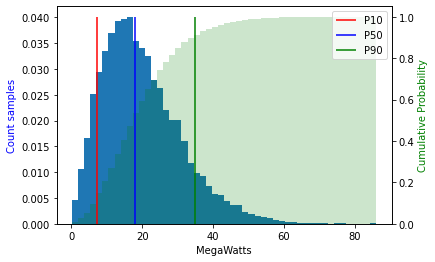

In [32]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx() 

ax1.hist(np.squeeze(data.posterior.MegaWatts),50,density=True)
ax1.set_ylabel('Count samples', color='blue')
ax1.set_xlabel('MegaWatts')

ax2.vlines(P10_MW,0,1,'r',label='P10')
ax2.vlines(P50_MW,0,1,'b',label='P50')
ax2.vlines(P90_MW,0,1,'g',label='P90')
ax2.set_ylabel('Cumulative Probability', color='green')
ax2.hist(np.squeeze(data.posterior.MegaWatts),50,density=True,cumulative=True,color='green',alpha=0.2)
ax2.legend(loc=1)

# Vprior from `pymc3`
$V_{prior} = max_a \sum_{i=1}^N Pr( Power = p_i ) v_a(Power = p_i)$

actions:

$a_0$ = nothing

$a_1$ = build 10 MW Factory

$a_2$ = build 20 MW Factory

SHOULD PUT INTERMEDIATE ACTION: Drill slim hole...

|   |  $a_0$=nothing | $a_1$=build 10MW  | $a_2$=build 20 MW  | ... $a_N$  |
|---|:-:|:-:|:-:|---|
| 10%: MW <= P10  |  0 |  P10_MW - 10MW | P10_MW - 20MW  |   |
| 40%: P10 < MW <= P50  |  0 | P30_MW -10MW  | P30_MW -20MW  |   |
| 40%: P50 < MW <= P90  |  0 |  P70_MW -10MW | P70_MW -20MW  |   |
| 10%: MW > P90  |  0 | P90_MW -10MW  |  P90_MW -20MW  |   |

In [33]:
print(P10_MW -10,P10_MW -20)
print(P50_MW -10,P50_MW -20)
print(P90_MW -10,P90_MW -20)
value_array = np.array([[0,P10_MW -10,P10_MW -20],
                        [0,P30_MW -10,P30_MW -20],
                        [0,P70_MW -10,P70_MW -20],
                        [0,P90_MW -10,P90_MW -20]])
value_array

-2.8184292450466977 -12.818429245046698
8.053455583017389 -1.9465444169826114
24.943429525606867 14.943429525606867


array([[  0.        ,  -2.81842925, -12.81842925],
       [  0.        ,   2.99328698,  -7.00671302],
       [  0.        ,  14.34431249,   4.34431249],
       [  0.        ,  24.94342953,  14.94342953]])

## Calculate Vprior with value_array and midpoint probabilities

These are the results of inside summation for all three drilling alternatives $a$ : the *expected outcome (average)* if we plan for at $x_{10MW}$,$x_{20MW}$, given the four possible resource/reservoir estimates.

In [34]:
v_a_midpoint = []
# Column-wise calculation to get v_a
for c in range(np.shape(value_array)[1]) :   
     cur_v_a_mp = np.sum([0.1, 0.4, 0.4, 0.1]*value_array[:,c])

     v_a_midpoint = np.append(v_a_midpoint,cur_v_a_mp)

print('\t do nothing, plan for 10MW, plan for 20MW')
v_a_midpoint

	 do nothing, plan for 10MW, plan for 20MW


array([ 0.        ,  9.14753982, -0.85246018])

<font size=4> $\max\limits_a$  : which action will result in highest *VALUE on average*

In [35]:
Vprior_mp = max(v_a_midpoint)
print('Vprior_mp', Vprior_mp)

Vprior_mp 9.147539816386011


18 cents / kiloWatt -hour (California) [ 1e3 kilowatt = megawatt]

$\frac{\$0.18 *1e3 kW}{megaWatt-hour}$ = $180 / megaWatt-hour 

In [36]:
Vprior_mp * 180

1646.557166949482

# Total (Sobol) Sensitivity index

In [37]:
pip install SALib

     |████████████████████████████████| 756 kB 12.6 MB/s 
     |████████████████████████████████| 81 kB 7.4 MB/s 
     |████████████████████████████████| 65 kB 3.0 MB/s 


In [39]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np



In [38]:
##EXAMPLE
# Define the model inputs
# problem = {
#     'num_vars': 3,
#     'names': ['x1', 'x2', 'x3'],
#     'bounds': [[-3.14159265359, 3.14159265359],
#                [-3.14159265359, 3.14159265359],
#                [-3.14159265359, 3.14159265359]]
# }

# # Generate samples
# param_values = saltelli.sample(problem, 1024)

# # Run model (example)
# Y = Ishigami.evaluate(param_values)

# # Perform analysis
# # Y : numpy.array
# #     A NumPy array containing the model outputs
# # calc_second_order : bool
# #     Calculate second-order sensitivities (default True)
# # num_resamples : int
# #     The number of resamples (default 100)
# # conf_level : float
# #     The confidence interval level (default 0.95)
# # print_to_console : bool
# #     Print results directly to console (default False)
# # keep_resamples : bool
# Si = sobol.analyze(problem, Y, print_to_console=True)

# # Print the first-order sensitivity indices
# print(Si['S1'])

## Dictionary of inputs, distributions and Y is MegaWatts

In [56]:
VolHeat = {
    'num_vars': 3,
    'names': ['resT', 'resVol', 'RecoveryFactor'],
    # 'bounds': [[np.min(data.posterior.resT),np.max(data.posterior.resT)],
    #            [np.min(np.squeeze(data.posterior.resVol)),np.max(np.squeeze(data.posterior.resVol))],
    #            [np.min(np.squeeze(data.posterior.RecoveryFactor)),np.max(np.squeeze(data.posterior.RecoveryFactor))]]
    'bounds': [[mu_T_res,sigma_T_res],
               [mu_volume,sigma_volume],
               #triangular with width (scale) and location of peak.
              # Location of peak is in percentage of width. Lower bound assumed to be zero.
               [high_R,mode_R/high_R]],
    #'groups': ['G1', 'G2', 'G3'],
    'dists': ['norm', 'norm', 'triang']
}

In [42]:
mode_R/high_R, mode_R, high_R

(0.5, 0.05, 0.1)

In [ ]:
#np.squeeze(data.posterior.MegaWatts.values)[0:10]
np.min(data.posterior.resT).values

array(72.54401534)

SALib.sample.saltelli.sample
*skip_values and N be a power of 2, where N is the desired number of samples*

In [57]:
param_values = saltelli.sample(VolHeat, 1024)
param_values

array([[9.04995854e+01, 4.37044261e+00, 4.73156373e-02],
       [1.49338952e+02, 4.37044261e+00, 4.73156373e-02],
       [9.04995854e+01, 5.28738780e+00, 4.73156373e-02],
       ...,
       [1.42351562e+02, 5.65016882e+00, 5.86306178e-02],
       [1.42351562e+02, 5.66567271e+00, 8.14463405e-02],
       [1.42351562e+02, 5.66567271e+00, 5.86306178e-02]])

Calculate MegaWatts

In [58]:
# Thermal Energy  = ((1.0-phi)*c_pr*rho_r + (phi*c_pf*rho_f))*(resT-T_ref)*resVol*1e9
muU_sa = ((1.0-phi)*c_pr*rho_r + (phi*c_pf*rho_f))*(param_values[:,0]-T_ref)*param_values[:,1]*1e9 #km**3 to m**3
# EQUATION 6 of Ciriaco: THERMAL ENERGY
MWe_sa = ((muU_sa*eta_c*param_values[:,2])/1e6)/(load_factor*lifespan*60*60*24*365) 

In [59]:
# np.shape(VolHeat) 
MWe_sa

array([ 8.47377047, 15.07766488, 10.25161858, ..., 22.89771703,
       31.89549511, 22.96054768])

In [60]:

# Perform analysis
Si = sobol.analyze(VolHeat, MWe_sa, num_resamples=100, print_to_console=True)


                      ST   ST_conf
resT            0.078822  0.011844
resVol          0.499245  0.056266
RecoveryFactor  0.515091  0.058840
                      S1   S1_conf
resT            0.056039  0.023938
resVol          0.416300  0.059917
RecoveryFactor  0.425053  0.056692
                                S2   S2_conf
(resT, resVol)            0.011254  0.045362
(resT, RecoveryFactor)    0.016488  0.045927
(resVol, RecoveryFactor)  0.071592  0.113585


In [61]:
# Print the first-order sensitivity indices
print(np.round(Si['S1'],4))

[0.056  0.4163 0.4251]


'ST' : If the total-order indices are substantially larger than the first-order indices, then there is likely higher-order interactions occurring.

In [62]:
print(np.round(Si['ST'],4))

[0.0788 0.4992 0.5151]


 We can look at the second-order indices to see these higher-order interactions:



In [63]:
print("x1-x2:", np.round(Si['S2'][0,1],3))
print("x1-x3:", np.round(Si['S2'][0,2],3))
print("x2-x3:", np.round(Si['S2'][1,2],3))

x1-x2: 0.011
x1-x3: 0.016
x2-x3: 0.072


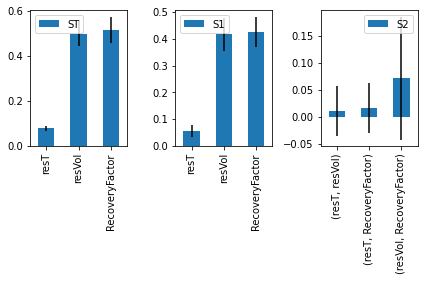

In [64]:
Si.plot()
plt.tight_layout()

In [65]:
resT

resT ~ Normal

In [ ]:
T_ref 

15